In [17]:
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
# from pymoo.problems import get_problem
from pymoo.core.problem import ElementwiseProblem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
import statsmodels.api as sm

import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
import matplotlib.animation as animation
from matplotlib.widgets import Slider, Button

from scipy.interpolate import splev, splrep, LSQUnivariateSpline, PchipInterpolator
from scipy.interpolate import CubicSpline, Akima1DInterpolator, interp1d
from scipy.integrate import simps
from sklearn.linear_model import LinearRegression
from functools import partial
from random import shuffle
from sklearn import linear_model
from tqdm.notebook import trange, tqdm
from pynverse import inversefunc
import scipy as sp
from joblib import Parallel, delayed 
import pandas as pd
from routines_model import *
from routines_GA import *
from multiprocessing import Pool
import multiprocessing
import pickle
import emcee
import corner
import pygtc 
import os

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from schwimmbad import JoblibPool

%load_ext line_profiler
%load_ext autoreload
%autoreload 2
# %reload_ext autoreload
# %matplotlib widget

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 15

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

In [18]:
e3_La10d = pd.read_csv("ETP/La10d.dat", delimiter="|")
e3_La10d = e3_La10d[["t","e"]].to_numpy().T
e3_La10d[0] = -e3_La10d[0]

In [28]:
t0, tf = 0, 5e3
inds = (e3_La10d[0]>=t0) & (e3_La10d[0]<=tf)
times, y_true = e3_La10d[:, inds]
y_true = (y_true-y_true.mean())/y_true.std()
# y = y + noise

In [32]:
N_data = len(y_true)
sigma_true = 0.7
rho_true = 0.9

white_noise = np.random.randn(N_data)*sigma_true
arparams = np.array([rho_true])
ar = np.r_[1, -arparams] # add zero-lag and negate
arma_process = sm.tsa.ArmaProcess(ar)
red_noise = arma_process.generate_sample(N_data)
red_noise = red_noise*np.sqrt(1-rho_true**2)*sigma_true
noise = red_noise

y = y_true + noise

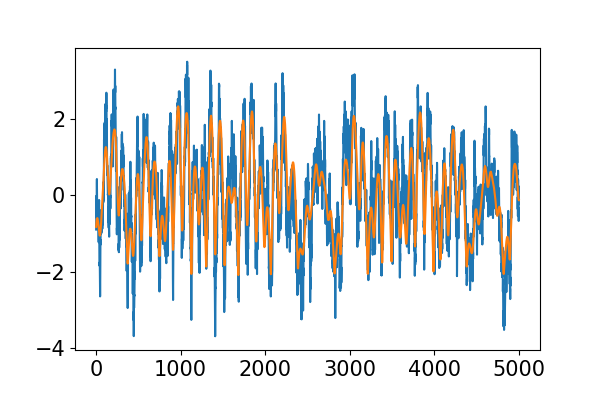

In [33]:
%matplotlib widget
plt.plot(times, y)
plt.plot(times, y_true)

# Model

In [62]:
coef_time = 1e3


b_k = np.array([0.018986, 0.016354, 0.013055, 0.008849, 0.004248])/0.022 #
muy_k = np.array([4.257564, 7.456665, 17.910194, 17.366595, 5.579378])
phi_k = np.array([30.739, -157.801, 140.577, -55.885, 77.107])
phi_k = phi_k/180/3600*np.pi
muy_k = muy_k/180/3600*np.pi*coef_time

p0 = 50.467718
# p0 = 40
p0 = p0/180/3600*np.pi*coef_time

# b_k

# ordering = [4, 1, 3, 2, 0]
# b_k = b_k[ordering]
# muy_k = muy_k[ordering]
# phi_k = phi_k[ordering]


fe_k = np.array([3.199279, 13.651920, 10.456224, 13.109803, 9.909679])
fe_k = fe_k/180/3600*np.pi*coef_time
N_terms = 5
fe_k = fe_k[:N_terms]
fs = np.hstack([muy_k + p0, fe_k])
print(fs)
print(2*np.pi/fs)

[0.26531565 0.28082533 0.33150547 0.32887003 0.27172399 0.01551054
 0.06618638 0.0506932  0.06355812 0.04804348]
[ 23.68192456  22.37399749  18.95348896  19.10537518  23.12341035
 405.09127213  94.93170191 123.94531716  98.85732074 130.78122914]


In [50]:
fe_k

array([0.01551054, 0.06618638])

## When time is known

In [63]:
reg = linear_model.LinearRegression()
X = generate_X_linReg(np.ones_like(fe_k), fe_k, times)
reg.fit(X, y_true)
y_pred = reg.predict(X)
# y_true = X @ ABtrue
# y_pred = X @ reg.coef_

0.7756222153943333 0.5235491211838025


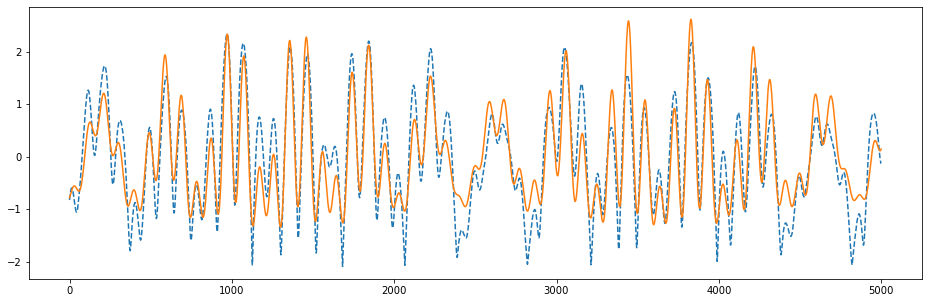

In [66]:
%matplotlib inline
plt.figure(figsize=(16,5))
# plt.plot(times, y)
plt.plot(times, y_true, "--")
plt.plot(times, y_pred)
print(r2_score(y_true, y_pred), r2_score(y, y_pred))